# Build Coal Supply suitability for GRIDCERF


The following code was used to build the coal supply suitability layers for GRIDCERF. GRIDCERF does not provide the source data directly due to some license restrictions related for direct redistribution of the unaltered source data.  However, the following details the provenance associated with each source dataset and how they were processed.


## 1. Setup environment

### 1.1 Download GRIDCERF

Download the GRIDCERF package if you have not yet done so from here:  https://doi.org/10.5281/zenodo.6601789.  Please extract GRIDCERF inside the `data` directory of this repository as the paths in this notebook are set to that expectation.


### 1.2 Data description


**Title**:  Energy Information Association (EIA) U.S. Coal Mining Locations
- **Description from Source**:  The U.S. Energy Information Administration (EIA) provides impartial and independent data on the nation’s energy infrastructure, its sources, flows, and end uses, as well as forecasts and outlooks. Location information for specific extraction activities, as well as power plants and other supply chain components, can help reveal the regional nature of specific impacts and the often large distances between those effects and end-use drivers. This is a point dataset representing operating surface and underground coal mines in the United States in 2012. These data originate from the U.S. Energy Information Administration, Form EIA-7A “Coal Production and Preparation Report” and the U.S. Department of Labor, Mine Safety and Health Administration Form 7000-2, “Quarterly Mine Employment and Coal Production Report.”
- **Source URL**:  https://www.sciencebase.gov/catalog/item/5748a4cbe4b07e28b664dd78
- **Date Accessed**:  8/1/23
- **Citation**
> Energy Information Association (EIA). Energy Information Association U.S. Coal Mining Locations. ScienceBase-Catalog https://www.sciencebase.gov/catalog/item/5748a4cbe4b07e28b664dd78 (2017).


**Title**:  U.S. Department of Transportation (USDOT) Bureau of Transportation Statistics (BTS)  North American Rail Network Nodes
- **Description from Source**:  The rail nodes dataset supports the topology of the North American Rail Network (NARN) and attributes information for use in network analysis applications. The North American Rail Network (NARN) Rail Nodes dataset was created in 2016 and was updated on July 14, 2023 from the Federal Railroad Administration (FRA) and is part of the U.S. Department of Transportation (USDOT)/Bureau of Transportation Statistics (BTS) National Transportation Atlas Database (NTAD). The NARN Rail Nodes dataset is a database of North America's railway system at 1:24,000 or better within the United States. The data set covers all 50 States, the District of Columbia, Mexico, and Canada. The dataset holds topology of the network and provides geographic location information.
- **Source URL**:  https://data-usdot.opendata.arcgis.com/datasets/usdot::north-american-rail-network-nodes/about
- **Date Accessed**:  8/1/23
- **Citation**
> U.S. Department of Transportation. North American Rail Network Nodes. U.S. Department of Transportation https://data-usdot.opendata.arcgis.com/datasets/usdot::north-american-rail-network-nodes/explore?location=34.085743%2C-108.310932%2C3.96 (2023).


**Title**:  U.S. Department of Transportation (USDOT) Bureau of Transportation Statistics (BTS) Navigable Waterway Network Lines
- **Description from Source**:  The Navigable Waterway Network Lines dataset is periodically updated by the United States Army Corp of Engineers (USACE) and is part of the U.S. Department of Transportation (USDOT)/Bureau of Transportation Statistics (BTS) National Transportation Atlas Database (NTAD). The National Waterway Network (Lines) is a comprehensive network database of the Nation's navigable waterways. The dataset covers the 48 contiguous states plus the District of Columbia, Hawaii, Alaska, Puerto Rico and water links between. It consists of a line feature class of the National Waterway Network (NWN), which is based on a route feature class for the NWN update regions (“1” through “7”, as well as the open ocean region “0”) and route event table with linear referencing system measures for NWN links. This dataset is a feature class with associated measures (in miles) that are used for finding distances, locating features, and displaying route event layers. It was exported from this route event layer. The nominal scale of the dataset varies with the source material. The majority of the information is at 1:100,000 with larger scales used in harbor/bay/port areas and smaller scales used in open waters. These data could be used for analytical studies of waterway performance, for compiling commodity flow statistics, and for mapping purposes.
- **Source URL**:  https://geodata.bts.gov/datasets/usdot::navigable-waterway-network-lines/about
- **Date Accessed**:  8/1/23
- **Citation**
> U.S. Department of Transportation. Navigable Waterway Network Lines. Bureau of Transportation Statistics https://geodata.bts.gov/datasets/usdot::navigable-waterway-network-lines/about (2023).


### 1.3 Import modules


In [2]:
import os

import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
from rasterio import features


## 2. Configuration


In [3]:
# get the parent directory path to where this notebook is currently stored
root_dir = os.path.dirname(os.getcwd())

# data directory in repository
data_dir = os.path.join(root_dir, "data")

# GRIDCERF data directory from downloaded archive
gridcerf_dir = os.path.join(data_dir, "gridcerf")

# GRIDCERF reference data directory
reference_dir = os.path.join(gridcerf_dir, "reference")

# GRIDCERF source data directory
source_dir = os.path.join(gridcerf_dir, "source", "technology_specific")

# GRIDCERF technology_specific data directory
technology_specific_dir = os.path.join(gridcerf_dir, "technology_specific")

# template siting mask raster
template_raster = os.path.join(reference_dir, "gridcerf_sitingmask.tif")

# CONUS boundary shapefile
conus_shpfile = os.path.join(reference_dir, "gridcerf_conus_boundary.shp")

# shapefile location for the source coal mines
coalmines_file = os.path.join(source_dir, "eia_coal-mines", "Coal_Mining_Locations.shp")

# shapefile location for the source rail nodes
railnodes_file = os.path.join(source_dir, "usdot_rail-nodes", "North_American_Rail_Network_Nodes.shp")

# shapefile location for the source navigable water
navwater_file = os.path.join(source_dir, "usdot_navigable-waterways", "Waterway_Network.shp")

# output rasters
output_file = os.path.join(technology_specific_dir, "gridcerf_coalmines20km_railnodes5km_navwaters5km_conus.tif")


## 4. Generate suitability rasters

### 4.1 Functions to build suitability

In [4]:
def vector_to_raster(template_raster, gdf, value_field, output_raster):
                     
    # open the template raster and extract metadata and land mask
    with rasterio.open(template_raster) as template:

        metadata = template.meta.copy()

        # update raster data type
        metadata.update(dtype=np.int16)

        # extract land mask
        land_mask = template.read(1)
        land_mask = np.where(land_mask == 0, np.nan, 1)

        # write output raster
        with rasterio.open(output_raster, 'w+', **metadata) as out:

            out_arr = out.read(1)

            # build shapes to rasterize from target geometry and field
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[value_field]))

            # burn features
            burned = features.rasterize(shapes=shapes, 
                                        fill=1, 
                                        out=out_arr, 
                                        transform=out.transform)
            
            burned = np.where(burned == 1, 0, 1).astype(np.float64)
            
            # apply land mask
            burned *= land_mask
            
            # make nan excluded
            burned = np.where(np.isnan(burned), 1, burned)

            out.write_band(1, burned.astype(np.int16))


### 4.2 Set standard raster template


In [5]:
# open the template raster and extract metadata and land mask
with rasterio.open(template_raster) as template:

    metadata = template.meta.copy()

    # update raster data type
    metadata.update(dtype=np.float64)

    # extract land mask
    land_mask = template.read(1)
    land_mask = np.where(land_mask == 0, np.nan, 1)

    # get the template CRS
    template_crs = template.crs


### 4.3 Generate suitability

#### 4.3.1 Build gridcerf_usdot_railnodes_navwaters_greaterthan5km.tif

<Axes: >

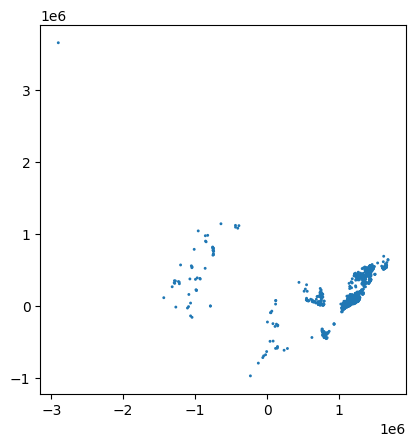

In [7]:
# read in coal mine data and reproject to the target CRS
coal_gdf = gpd.read_file(coalmines_file).to_crs(template_crs)

# buffer by 20 km (20000 m)
coal_gdf["geometry"] = coal_gdf["geometry"].buffer(20000)

# add in field for rasterization
coal_gdf["rval"] = 1

coal_gdf.plot()


In [8]:
# read in rail nodes shapefile and reproject to the target CRS
rail_gdf = gpd.read_file(railnodes_file)[["COUNTRY", "STATE", "geometry"]].to_crs(template_crs)


In [9]:
# keep only US nodes
rail_gdf = rail_gdf.loc[rail_gdf["COUNTRY"] == "US"].copy()

# remove all non-CONUS state designations
rail_gdf = rail_gdf.loc[~rail_gdf["STATE"].isin(["HI", "AK", "BD"])].copy()


In [10]:
# buffer by 5 km (5000 m)
rail_gdf["geometry"] = rail_gdf["geometry"].buffer(5000)


<Axes: >

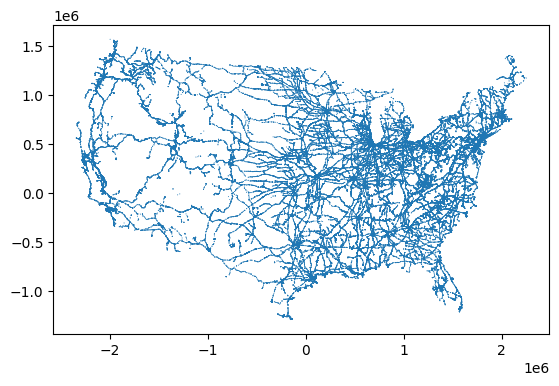

In [11]:
# create a field to use for rasterization
rail_gdf["rval"] = 1
rail_gdf.plot()

In [12]:
# read in rail nodes shapefile and reproject to the target CRS
nav_gdf = gpd.read_file(navwater_file).to_crs(template_crs)


In [13]:
# buffer by 5 km (5000 m)
nav_gdf["geometry"] = nav_gdf["geometry"].buffer(5000)


In [14]:
# create a field to use for rasterization
nav_gdf["rval"] = 1


<Axes: >

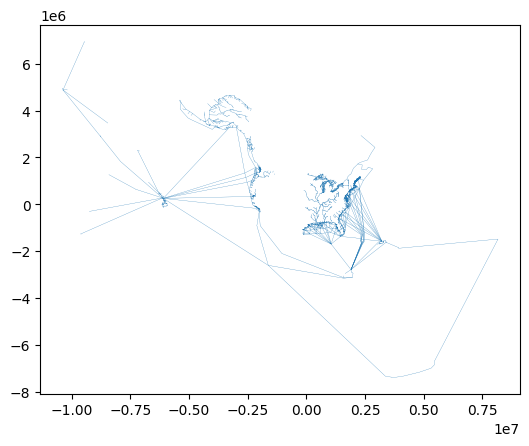

In [15]:
nav_gdf.plot()

In [16]:
# merge the rail and navigable waters data frames
mdf = pd.concat([
    coal_gdf[["rval", "geometry"]], 
    rail_gdf[["rval", "geometry"]], 
    nav_gdf[["rval", "geometry"]]
])


<Axes: >

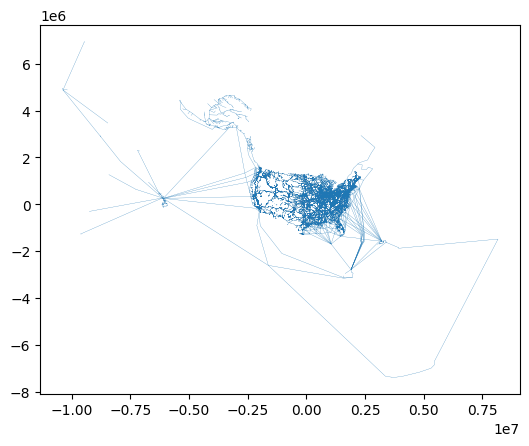

In [17]:
mdf.plot()

In [18]:
# rasterize combined rail and navigable waters data
vector_to_raster(template_raster, 
                 mdf, 
                 "rval", 
                 output_file)

/Users/mong275/.pyenv/versions/3.11.0/envs/gridcerf_3.11/lib/python3.11/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 146 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/mong275/.pyenv/versions/3.11.0/envs/gridcerf_3.11/lib/python3.11/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 248 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasterized.'.format(geom, index), ShapeSkipWarning)
/Users/mong275/.pyenv/versions/3.11.0/envs/gridcerf_3.11/lib/python3.11/site-packages/rasterio/features.py:328: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 378 will not be rasterized.
  warnings.warn('Invalid or empty shape {} at index {} will not be rasteriz